In [1]:
# configuration cell

no_epochs = 30

act_fn_dict = {
    'conv1':'relu',
    'conv2':'relu',
    'conv3':'relu',
    'conv4':'relu',
    'conv5':'relu',
    'fc1':'relu'
}

kernel_size_list = [3,3,3,3,3]
no_kernel_list = [32,32,64,64,128]
dropout_list = [0,0,0.5]
fc1_nodes = 1024
no_classes = 10
lr = 0.0001
lr_schedule = 0.5 # per 10 epochs half the learning rate

In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import wandb
from util import*
import copy

In [3]:
from torch.nn import ReLU

# check if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda == True:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
device = torch.device("cpu")

In [5]:
modelName = 'Best_CNN_5Layers_iNaturalist_guided_backprop'

In [6]:
ckp_path = "./Best_CNN_5Layers_iNaturalist/checkpoint/current_checkpoint.pt"
best_ckp_path = "./Best_CNN_5Layers_iNaturalist/best_model/best_model.pt"

In [7]:
wandb.init(project=modelName)

wandb: Currently logged in as: rayanz (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.26 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [8]:
batch_size = 1
datasetTrain, datasetVal, datasetTest = load_datasets()
loaders = data_loader(datasetTrain, datasetVal, datasetTest, batch_size)

In [9]:
def recreate_image(im_as_var):
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im

In [10]:
def act_fn(act_name):
    if act_name=="relu":
        return nn.ReLU(inplace=True)
    
    elif act_name=="sigmoid":
        return nn.Sigmoid(inplace=True)
    
    elif act_name=="tanh":
        return nn.Tanh(inplace==True)

In [11]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3 ,BN=True , NL="relu", stride = 1, padding = 0):
        super(conv_block, self).__init__()
        self.BN=BN
        self.NL=NL
        k = kernel_size
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = k, stride = stride, padding = padding, bias=False)
        
        if self.BN==True:
            self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
            
        self.act = act_fn(NL)
        
    def forward(self, x):
        x = self.conv(x)
        
        if self.BN==True:
            x = self.bn(x)
        
        return self.act(x)

In [12]:
class fc_block(nn.Module):
    def __init__(self, in_channels, out_channels, BN=False , NL="relu"):
        super(fc_block, self).__init__()
        self.BN=BN
        self.NL=NL
        self.fc = nn.Linear(in_channels, out_channels)
        
        if self.BN==True:
            self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
            
        self.act = act_fn(NL)
        
    def forward(self, x):
        x = self.fc(x)
        
        if self.BN==True:
            x = self.bn(x)
        
        x = self.act(x)
        
        return x

In [13]:
def get_fc_in(input_dim, kernel_size_list, no_kernel_list):
    H = input_dim
    fc_in = H - kernel_size_list[0] + 1 # conv1
    fc_in = (fc_in - 2) //2  + 1 # max pool 1
    fc_in = fc_in - kernel_size_list[1] + 1 # conv2
    fc_in = (fc_in - 2) //2  + 1 # max pool 2
    fc_in = fc_in - kernel_size_list[2] + 1 #conv3
    fc_in = (fc_in - 2) //2  + 1 # max pool 3
    fc_in = fc_in - kernel_size_list[3] + 1 #conv4
    fc_in = (fc_in - 2) //2  + 1 # max pool 4
    fc_in = fc_in - kernel_size_list[4] + 1 #conv5
    fc_in = (fc_in - 2) //2  + 1 # max pool 5
    #print(fc_in)
    return fc_in * fc_in * no_kernel_list[4]

In [14]:
class CNN_5layer(nn.Module):
    def __init__(self, kernel_size_list, no_kernel_list, act_fn_dict, dropout_list, fc1_nodes, no_classes):
        super(CNN_5layer, self).__init__()
        self.dropout_list = dropout_list
        self.input_dim = 224
        #self.input_dim = 128
        self.conv1 = conv_block(3, no_kernel_list[0], kernel_size=kernel_size_list[0], BN=False, NL=act_fn_dict['conv1'])
        self.maxpool1 = nn.MaxPool2d((2, 2))
        self.conv2 = conv_block(no_kernel_list[0], no_kernel_list[1], kernel_size=kernel_size_list[1], BN=True, NL=act_fn_dict['conv2'])
        self.maxpool2 = nn.MaxPool2d((2, 2))
        
        if self.dropout_list[0]!=0:
            self.dropout1 = nn.Dropout(dropout_list[0])

        self.conv3 = conv_block(no_kernel_list[1], no_kernel_list[2], kernel_size=kernel_size_list[2], BN=True, NL=act_fn_dict['conv3'])
        self.maxpool3 = nn.MaxPool2d((2, 2))
        self.conv4 = conv_block(no_kernel_list[2], no_kernel_list[3], kernel_size=kernel_size_list[3], BN=True, NL=act_fn_dict['conv4'])
        self.maxpool4 = nn.MaxPool2d((2, 2))
        
        if self.dropout_list[1]!=0:
            self.dropout2 = nn.Dropout(dropout_list[1])

        self.conv5 = conv_block(no_kernel_list[3], no_kernel_list[4], kernel_size=kernel_size_list[4], BN=True, NL=act_fn_dict['conv5'])
        self.maxpool5 = nn.MaxPool2d((2, 2))
        
        self.fc1_in_features = get_fc_in(self.input_dim, kernel_size_list, no_kernel_list)
        
        self.fc1 = fc_block(self.fc1_in_features, fc1_nodes , NL=act_fn_dict['fc1'])
        
        if self.dropout_list[2]!=0:
            self.dropout3 = nn.Dropout(dropout_list[2])
        
        self.fc2 = nn.Linear(fc1_nodes, no_classes)
    
    
    def forward(self, x):
        if x.shape[2]!=self.input_dim:
            print("input dim not matched")
            return
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        
        if self.dropout_list[0]!=0:
            x = self.dropout1(x)
        
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.conv4(x)
        x = self.maxpool4(x)
        
        if self.dropout_list[1]!=0:
            x = self.dropout2(x)
        
        x = self.conv5(x)
        x = self.maxpool5(x)
        
        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)
        if self.dropout_list[2]!=0:
            x = self.dropout3(x)
        
        x = self.fc2(x)
        
        return x

In [15]:
model = CNN_5layer(kernel_size_list, no_kernel_list, act_fn_dict, dropout_list, fc1_nodes, no_classes)

In [16]:
#model = model.to(device)

In [17]:
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = StepLR(optimizer, step_size=10, gamma=lr_schedule)
criterion = nn.CrossEntropyLoss()

In [18]:
# load the saved last checkpoint
best_trained_model, optimizer, start_epoch, valid_loss, valid_acc, valid_loss_min = load_ckp(best_ckp_path, model, optimizer)

In [19]:
class_names = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']

In [20]:
class GuidedBackprop():
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model._modules.items())[0][1].conv
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        def relu_backward_hook_function(module, grad_in, grad_out):
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        
        msReLU = list(filter(lambda m: type(m) == torch.nn.modules.ReLU or type(m) == torch.nn.modules.ReLU6, self.model.modules()))
        print(msReLU)
        for i, m in enumerate(msReLU): 
            m.register_backward_hook(relu_backward_hook_function)
            m.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image):
        # Forward pass
        grads_10=[]
        self.image = image.requires_grad_()
        model_output = self.model(self.image)
        np_arr = model_output.detach().numpy()
        i = np.flatnonzero(np_arr)
        ix = np.random.choice(len(i), 10 , replace=False)
        ind = torch.tensor(ix)
        sh = model_output.shape
        u_ind = unravel_index(ind, sh)
        
        for i in range(10):
            model_output = self.model(self.image)
            self.model.zero_grad()
            one_hot_output = torch.zeros_like(model_output)
            one_hot_output[tuple(u_ind[i])] = model_output[tuple(u_ind[i])]
            model_output.backward(gradient=one_hot_output)
            # Convert Pytorch variable to numpy array
            # [0] to get rid of the first channel (1,3,224,224)
            gradients_as_arr = self.gradients.data.numpy()[0]
            #grads_10.append(gradients_as_arr*500)
            #x=np.transpose(x, (1, 2, 0))
            grads_10.append(wandb.Image(np.transpose(gradients_as_arr, (1, 2, 0)), caption="Neuron : {}".format(i+1)))
        return grads_10

In [21]:
child_counter = 0
for child in best_trained_model.children():
    print(" child", child_counter, "is:")
    print(child)
    child_counter += 1

 child 0 is:
conv_block(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (act): ReLU(inplace=True)
)
 child 1 is:
MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
 child 2 is:
conv_block(
  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU(inplace=True)
)
 child 3 is:
MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
 child 4 is:
conv_block(
  (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU(inplace=True)
)
 child 5 is:
MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
 child 6 is:
conv_block(
  (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affi

In [22]:
best_trained_model_trunc = nn.Sequential(*list(best_trained_model.children())[:-4])

In [23]:
best_trained_model_trunc

Sequential(
  (0): conv_block(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (act): ReLU(inplace=True)
  )
  (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (2): conv_block(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU(inplace=True)
  )
  (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (4): conv_block(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU(inplace=True)
  )
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): conv_block(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=T

In [24]:
def unravel_index(
    indices: torch.LongTensor,
    shape: torch.IntTensor,
) -> torch.LongTensor:
    coord = []

    for dim in reversed(shape):
        coord.append(indices % dim)
        indices = indices // dim

    coord = torch.stack(coord[::-1], dim=-1)

    return coord


In [25]:
dataIterator = iter(loaders['test'])

#(image, target) = next(dataIterator)

for i in range(4):
    (image, target) = next(dataIterator)

gbp = GuidedBackprop(best_trained_model_trunc)

[ReLU(inplace=True), ReLU(inplace=True), ReLU(inplace=True), ReLU(inplace=True), ReLU(inplace=True)]


In [26]:
guided_grads = gbp.generate_gradients(image)

D:\Anaconda3\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


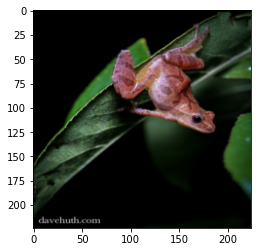

In [27]:
plt.imshow(recreate_image(image))

In [28]:
guided_grads.insert(0,wandb.Image(
            recreate_image(image), caption="Actual image"))

In [29]:
wandb.log({"GuidedPropagation fo 10 neurons": guided_grads})